Import libraries

In [13]:
import math
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.opflow import X, Y, Z, I, CircuitStateFn
from qiskit.visualization import plot_histogram
pi = math.pi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from scipy.optimize import curve_fit
import re

Calculation of variational ground state energies $E_1$ and $E_2$ and fit for $E_N$

Lowest trial energy for N=1:  -0.436582 MeV
Lowest trial energy for N=2:  -1.7491336040155567 MeV


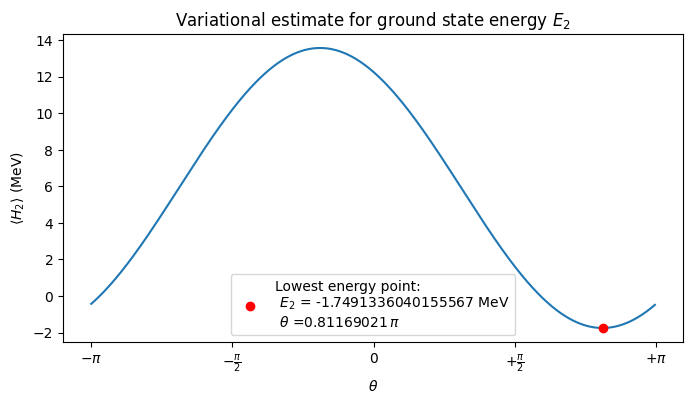

In [23]:
# Define deuterion Hamiltonian in the computational basis
Hamilt_1 = 0.218291 * (Z-I)
Hamilt_2 = (5.906709 * I^I) + (0.218291 * Z^I) - (6.125 * I^Z) - (2.143304 * X^X) - (2.143304 * Y^Y)

# Deuteron parameters
m = 1875.612942 # MeV / c^2
hbar_c = 197.326980 # Mev fm
c = 2.99792458e+23 # fm /s
omega = c* 7.0/hbar_c

# The ground state for H_1 is obtained as <1|H_1|1>, no need to use variational method
state = Statevector.from_int(1,2)
E_1 =  state.expectation_value(Hamilt_1).real 

# Loop over variational parameter theta for calculation of <H_2>
theta = np.arange(-3.14,+3.14,0.01)
exp_val_2 = np.empty(len(theta))

for kk in range(0, len(theta)):
    # Create a Quantum Circuit acting on the q register, default both in the state |0>
    circuit = QuantumCircuit(2)

    # Add X gate to qubit 0
    circuit.x(0)

    # Rotation around y axis on qubit 1
    circuit.ry(theta[kk], 1)

    # Add CNOT, control q1, target q0
    circuit.cx(1,0)

    # Initialize state
    state= Statevector.from_int(0, 4)

    # Evolve the state by the quantum circuit
    state = state.evolve(circuit)

    exp_val_2[kk]=state.expectation_value(Hamilt_2).real

# Lowest trial energy for <H_2>
E_2 = min(exp_val_2)

# Draw the circuit
#circuit.draw('mpl')

# Plot of energy as a function of theta
# Plot style options
w = 8
h = 4
fontsize = 12
cmap = plt.get_cmap('tab20')
# <H_2>(theta)
lbl = 'Lowest energy point:\n $E_2$ = ' + str(E_2) + ' MeV\n $\\theta$ =' + str(theta[np.where(exp_val_2 == E_2)]/pi).replace('[', '').replace(
    ']', '') + '$\,\\pi$'
fig = plt.figure(figsize=(w,h))
ax = fig.add_subplot(111)
ax.plot(theta, exp_val_2)
unit = 0.5
x_tick = np.arange(-1, +1 + unit, unit)
x_label = [r'$-\pi $', r'$-\frac{\pi}{2}$', r'$0$', r'$+\frac{\pi}{2}$', r'$+\pi$']
ax.set_xticks(x_tick * pi)
ax.set_xticklabels(x_label, fontsize=10)
plt.scatter(theta[np.where(exp_val_2 == E_2)], E_2, zorder= 5, color='red', label = lbl )
plt.legend()
plt.xlabel("$\\theta$")
plt.ylabel("$\\langle H_2 \\rangle$ (MeV)")
plt.title('Variational estimate for ground state energy $E_2$')
# Results
print('Lowest trial energy for N=1: ', E_1, 'MeV')
print('Lowest trial energy for N=2: ', E_2, 'MeV')


In [25]:
# List of trial energies
E_data = np.array([E_1 , E_2])

# Effective hard-wall radius for N=1 and N=2
L = np.array([9.14, 11.45])  # fm

# Harmonic oscillator variant of Lüscher formula
#   k: bound state momentum fm^(-1)
#   gamma: asymptotic normalization coefficient fm^(-1/2)
def luscher(l, k, gamma):
    return -hbar_c*hbar_c*k*k/(2*m)*(1 - 2*gamma*gamma*np.exp(-2*k*l)/k - 4*(gamma**4)*l*np.exp(-4*k*l)/k)

# Fit to k and gamma
param, cov = curve_fit(luscher, L, E_data)

#delta_E_2 = (hbar_c*hbar_c/(2*m))*(param[0]*param[1]*param[1]*np.exp(-2*param[0]*L[1])+2*param[0]*(param[1]**4)*L[1]*np.exp(-4*param[0]*L[1]))
#print('Alternative result: ', E_2 - delta_E_2, 'MeV')

# Results
print('Fit parameters [k gamma]=', param)
print('Infinite-basis extrapolated binding energy: ', -hbar_c*hbar_c*param[0]*param[0]/(2*m), 'MeV')

Fit parameters [k gamma]= [ 0.42298008 12.68968294]
Infinite-basis extrapolated binding energy:  -1.85711818182897 MeV
